In [ ]:
torch.cuda.empty_cache()
import sys
sys.modules[__name__].__dict__.clear()
import gc
gc.collect()
# !pip install lightning

In [3]:
!pip show torch

Name: torch
Version: 2.0.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /opt/conda/lib/python3.10/site-packages
Requires: filelock, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, catalyst, easyocr, fastai, kornia, pytorch-ignite, pytorch-lightning, timm, torchaudio, torchdata, torchmetrics, torchtext, torchvision


# Imports
---

In [64]:
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision as tv
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [65]:
def make_cm(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for images, labels in test_loader:  # Iterate over the validation dataset
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            predictions.extend(predicted.cpu().numpy())
            ground_truth.extend(labels.cpu().numpy())

    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)
    cm = confusion_matrix(ground_truth, predictions)
    return cm
    
def plot_cm(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.show()

# Data
---

In [66]:
import os
import pandas as pd
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url

class CUB2002011(Dataset):
    url = 'https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz'
    filename = 'CUB_200_2011.tgz'
    tgz_md5 = '97eceeb196236b17998738112f37df78'

    def __init__(self, root=os.path.join(".", "data"), train=True, download=False, transform=None, target_transform=None, n_classes=None):
        self.root = root
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        
        if download:
            self._download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')
        if n_classes:
            self.data = self.data[self.data.target <= n_classes]

    def _download(self):
        import tarfile
        
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        
        download_url(self.url, self.root, self.filename, self.tgz_md5)
        
        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)
    
    def _check_integrity(self):
        try:
            self._load_metadata()
        except Exception:
            return False
        
        for index, row in self.data.iterrows():
            filepath = os.path.join(self.root, 'CUB_200_2011', 'images', row.filepath)
            if not os.path.isfile(filepath):
                print(filepath)
                return False
        return True
    
    def _load_metadata(self):
        images             = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'images.txt')            , sep=' ', names=['img_id', 'filepath'])
        image_class_labels = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'image_class_labels.txt'), sep=' ', names=['img_id', 'target'])
        train_test_split   = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'train_test_split.txt')  , sep=' ', names=['img_id', 'is_training_img'])

        self.data = images.merge(image_class_labels, on='img_id')\
                          .merge(train_test_split  , on='img_id')
        
        self.data = self.data[self.data.is_training_img == self.train]
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        path = os.path.join(self.root, 'CUB_200_2011', 'images', sample.filepath)
        target = sample.target - 1  # Targets start at 1 by default, so shift to 0
        img = (tv.io.read_image(path)/255)
        
        if img.shape[0] == 1:
            img = img.expand(3, -1, -1)
        
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

In [67]:
n_classes = 8
batch_size = 64

transform = tv.transforms.Compose([
    tv.transforms.Resize(224, antialias=True),
    tv.transforms.CenterCrop(224),
])
target_transform = tv.transforms.Compose([
])

train_dataset = CUB2002011(train=True , download=True , transform=transform, target_transform=target_transform, n_classes=n_classes)
test_dataset  = CUB2002011(train=False, download=False, transform=transform, target_transform=target_transform, n_classes=n_classes)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True , num_workers=2)
test_loader  = DataLoader(test_dataset , batch_size=batch_size, shuffle=False, num_workers=2)

sample = next(iter(train_loader))

Files already downloaded and verified


In [25]:
sample[0].shape

torch.Size([64, 3, 299, 299])

# Model
---

In [81]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, n_filters):
        super().__init__()
        
        self.shortcut_branch = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=1),
            nn.BatchNorm2d(out_ch)
        )
        self.main_branch = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=n_filters, out_channels=out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch)
        )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(self.main_branch(x) + self.shortcut_branch(x))

class ExpertsBlock(nn.Module):
    def __init__(self, in_ch, out_ch, n_experts, n_filters):
        super().__init__()
        self.n_experts = n_experts
        self.experts = nn.ModuleList([ConvBlock(in_ch, out_ch, n_filters) for _ in range(n_experts)])
    
    def forward(self, x):
        expert_outputs = []
        for expert in self.experts:
            expert_output = expert(x)
            expert_outputs.append(expert_output)
        return expert_outputs

class RDE(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        
        self.backbone = torch.nn.Sequential(*list(tv.models.vgg16(weights='IMAGENET1K_V1').children())[:-1])
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        self.experts_block = ExpertsBlock(512, 64, n_classes, 16)
        self.cat = torch.cat
        self.conv = nn.Conv2d(64, 1, 7, 7)
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.experts_block(x)
        x = self.cat(x, dim=-1)
        x = self.conv(x).squeeze()
        return x

In [82]:
model = RDE(n_classes)
model.to(device)
clear_output()

In [83]:
sample_x.shape

torch.Size([64, 3, 224, 224])

In [84]:
# sample_x, sample_y = sample
# sample_x = sample_x.to(device)
# model(sample[0])

In [85]:
def train_loop(model, criterion, optimizer, n_epochs, train_loader):
    n_total_steps = len(train_loader)
    cout_step = int(n_total_steps/3)
    for epoch in range(n_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % cout_step == 0:
                print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 32
train_loop(model, criterion, optimizer, n_epochs, train_loader)

Epoch [1/32], Step [1/4], Loss: 2.1435
Epoch [1/32], Step [2/4], Loss: 1.8576
Epoch [1/32], Step [3/4], Loss: 1.5655
Epoch [1/32], Step [4/4], Loss: 1.4046
Epoch [2/32], Step [1/4], Loss: 0.3293
Epoch [2/32], Step [2/4], Loss: 0.3686
Epoch [2/32], Step [3/4], Loss: 0.1855
Epoch [2/32], Step [4/4], Loss: 0.1565


KeyboardInterrupt: 

In [147]:
cm1 = make_cm(model, test_loader, device)

[[19  1 10  0  0  0  0  0]
 [ 1 23  5  0  0  1  0  0]
 [ 5  3 18  1  0  0  1  0]
 [ 0  0  1 28  0  0  0  1]
 [ 1  0  0  0  9  0  3  1]
 [ 0  0  0  0  0  9  1  1]
 [ 0  0  0  0  3  2 17  1]
 [ 2  0  0  0  1  2  0 13]]


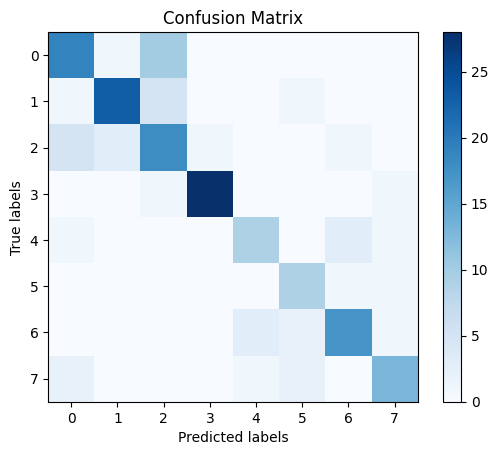

In [148]:
print(cm1)
plot_cm(cm1)

# New Expert
---

In [149]:
n_classes = 9
train_dataset = CUB2002011(train=True , download=True , transform=transform, target_transform=target_transform, n_classes=n_classes)
test_dataset  = CUB2002011(train=False, download=False, transform=transform, target_transform=target_transform, n_classes=n_classes)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True , num_workers=2)
test_loader  = DataLoader(test_dataset , batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


In [150]:
model.experts_block.experts.append(ConvBlock(512, 64, 16))
model.to(device)

RDE(
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

[[19  1 10  0  0  0  0  0  0]
 [ 1 23  5  0  0  1  0  0  0]
 [ 5  3 18  1  0  0  1  0  0]
 [ 0  0  1 28  0  0  0  1  0]
 [ 1  0  0  0  9  0  3  1  0]
 [ 0  0  0  0  0  9  1  1  0]
 [ 0  0  0  0  3  2 17  1  0]
 [ 2  0  0  0  1  2  0 13  0]
 [ 1  0  5 15  1  2  3  2  0]]


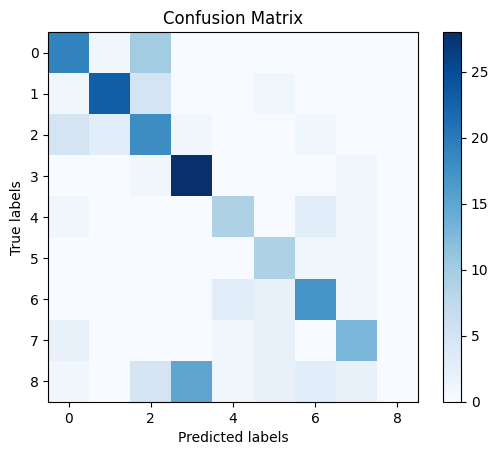

In [151]:
cm2 = make_cm(model, test_loader, device)
print(cm2)
plot_cm(cm2)

In [155]:
train_loop(model, criterion, optimizer, n_epochs, train_loader)

Epoch [1/32], Step [1/5], Loss: 0.0001
Epoch [1/32], Step [2/5], Loss: 0.0001
Epoch [1/32], Step [3/5], Loss: 0.0002
Epoch [1/32], Step [4/5], Loss: 0.0001
Epoch [1/32], Step [5/5], Loss: 0.0000
Epoch [2/32], Step [1/5], Loss: 0.0001
Epoch [2/32], Step [2/5], Loss: 0.0001
Epoch [2/32], Step [3/5], Loss: 0.0001
Epoch [2/32], Step [4/5], Loss: 0.0002
Epoch [2/32], Step [5/5], Loss: 0.0000
Epoch [3/32], Step [1/5], Loss: 0.0001
Epoch [3/32], Step [2/5], Loss: 0.0001
Epoch [3/32], Step [3/5], Loss: 0.0001
Epoch [3/32], Step [4/5], Loss: 0.0001
Epoch [3/32], Step [5/5], Loss: 0.0000
Epoch [4/32], Step [1/5], Loss: 0.0001
Epoch [4/32], Step [2/5], Loss: 0.0001
Epoch [4/32], Step [3/5], Loss: 0.0001
Epoch [4/32], Step [4/5], Loss: 0.0001
Epoch [4/32], Step [5/5], Loss: 0.0001
Epoch [5/32], Step [1/5], Loss: 0.0001
Epoch [5/32], Step [2/5], Loss: 0.0001
Epoch [5/32], Step [3/5], Loss: 0.0002
Epoch [5/32], Step [4/5], Loss: 0.0001
Epoch [5/32], Step [5/5], Loss: 0.0001
Epoch [6/32], Step [1/5],

[[11  2 11  0  0  0  0  2  4]
 [ 4 18  4  0  0  0  0  0  4]
 [ 3  6 12  0  0  0  1  0  6]
 [ 0  0  0 25  0  0  0  0  5]
 [ 0  0  0  0  6  0  3  1  4]
 [ 0  0  0  0  0  6  2  1  2]
 [ 1  0  0  0  2  2 16  0  2]
 [ 4  0  1  0  1  0  1  7  4]
 [ 0  1  0  4  0  1  1  0 22]]


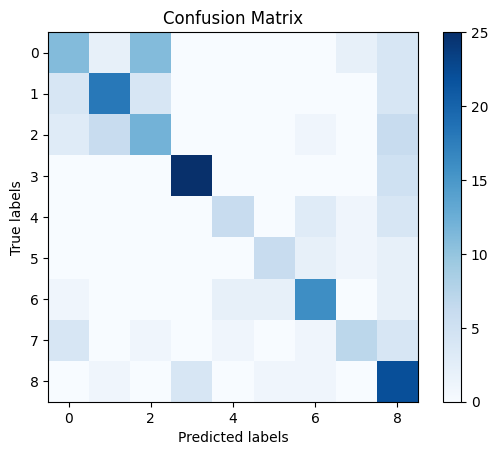

In [156]:
cm3 = make_cm(model, test_loader, device)
print(cm3)
plot_cm(cm3)